# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** 50  
**Kaggle challenge:** Classic (either `Classic` or `Deep learning`)  
**Kaggle team name (exact):** "*xx*"  

**Author 1 (SCIPER):** *Louis Cuicui (xxxxxx)*  
**Author 2 (SCIPER):** *Timur Ünver (xxxxx)*  
**Author 3 (SCIPER):** *Adrien Boschung (327221)*  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

> Your comments  
> ...

In [2]:
# IMPORTS FROM LABS #
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours

import cv2 # are we allowed?
import numpy as np

import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

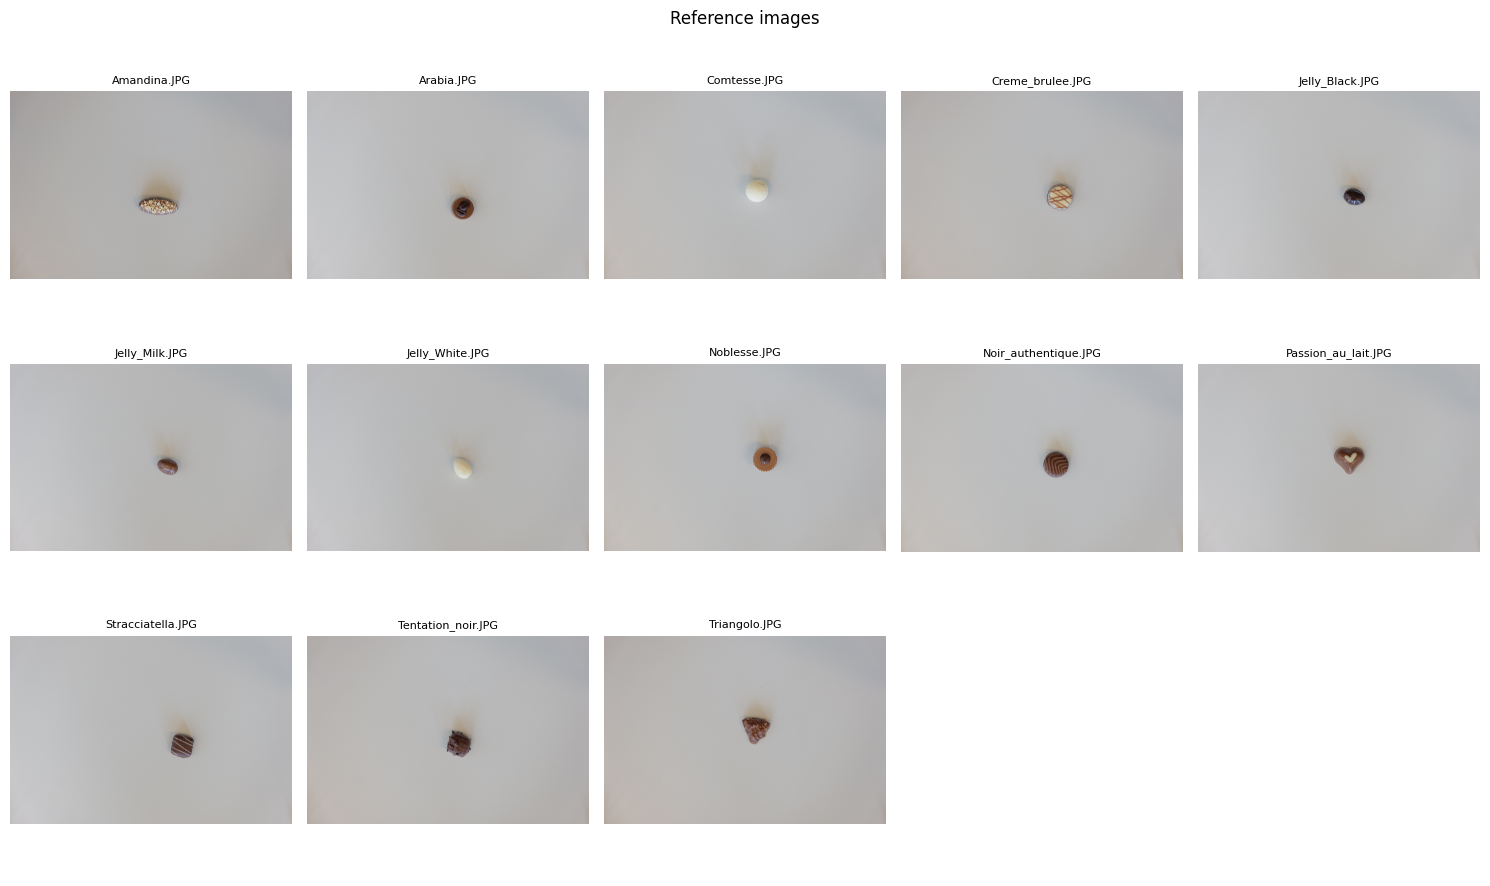

In [3]:
path_ref = '../project/dataset_project_iapr2025/references'

jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

# Define grid size (square-ish)
cols = 5
rows = (n_images + cols - 1) // cols  # Round up division

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

plt.suptitle('Reference images')

for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

# Pipeline
* Detect the chocolates edges and shape (and other features)
* Isolate the chocolates from each image 
* Match the chocolates with reference (translation/rotation invariance, scaling not needed) through shape, patterns, colors. A decision tree might be useful. For example, we have four different shapes (Square, Triangle, Circular, Oval). We also have different colors (White, Brown, Dark Brown/Black). Finally some of the chocolates have different patterns (strides, ...).

A problem would be to differentiate other items from chocolate and to predict the number of chocolates per image. A maximum would be to estimate the largest number of chocolates we could have and then set it as the number of chocolates we are looking for. Then when comparing the shapes of the items, we can consider the shapes that do not fit any of the shapes as OoD.

Here, I will try to isolate the chocolate from each of the reference chocolates. Each chocolate needs personnalized tuning due to differences in colors (main reason).

In [49]:
chocolates = []

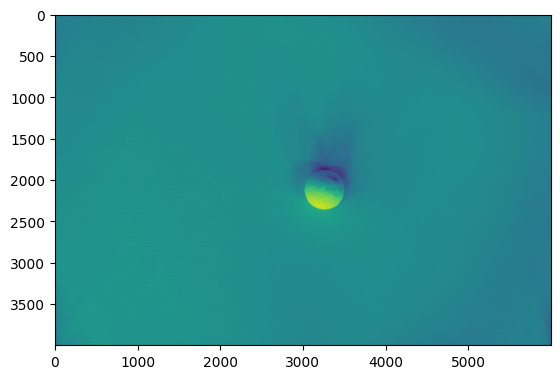

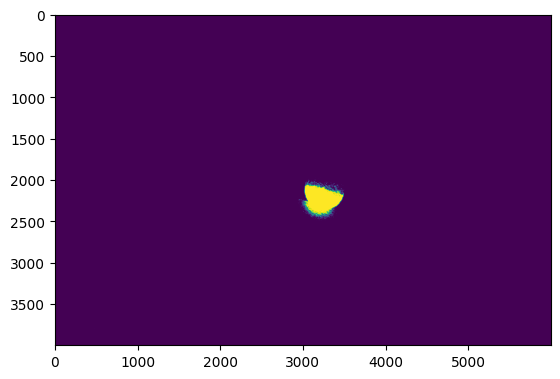

In [67]:
# Transform the image to an array and make it binary
img_path = os.path.join(path_ref, jpg_files[2])
img = Image.open(img_path).convert('L')
plt.figure()
plt.imshow(img)
img = np.array(img)
img = img > 195
plt.figure()
plt.imshow(img)

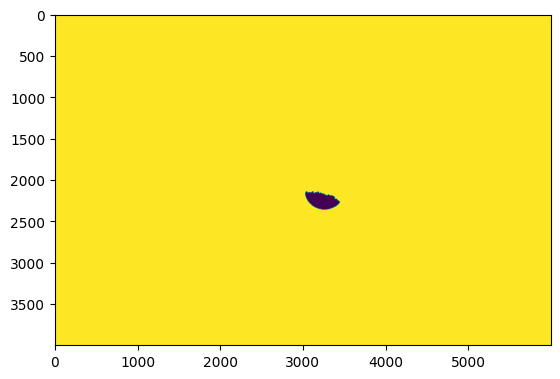

In [64]:
# Get the shape through morphology operations
footprint = disk(10)
img = closing(img, footprint)
img = remove_small_holes(img, 10000)
plt.imshow(img)

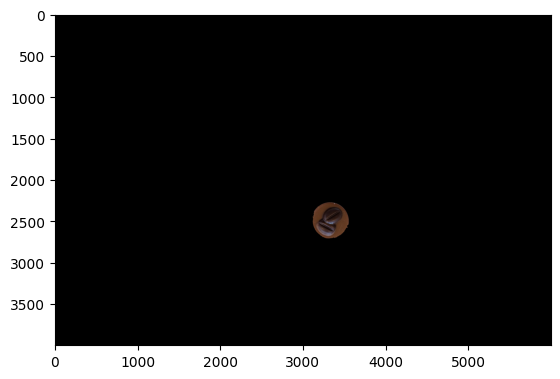

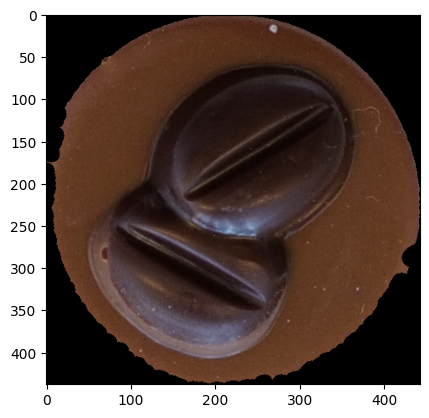

In [52]:
# Isolate the chocolate part of the original image
mask = img.copy() #np.all(img > 1, axis=2)
img_path = os.path.join(path_ref, jpg_files[1])
img_ref = mpimg.imread(img_path)
masked_img = np.zeros_like(img_ref)
masked_img[mask] = img_ref[mask]
plt.figure()
plt.imshow(masked_img)

# Crop it
coords = np.argwhere(mask) 
y0, x0 = coords.min(axis=0)
y1, x1 = coords.max(axis=0) + 1  # +1 because slicing is exclusive
cropped_img = masked_img[y0:y1, x0:x1]
plt.figure()
plt.imshow(cropped_img)

In [55]:
chocolates.append(cropped_img)

Automate if for all chocolates

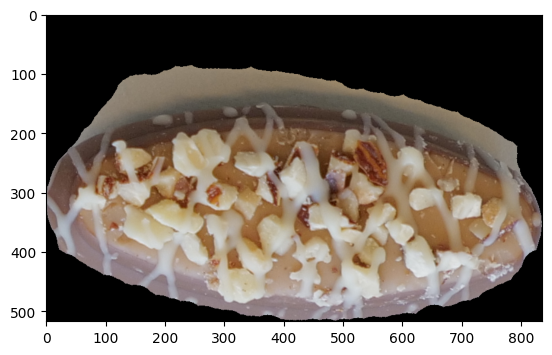

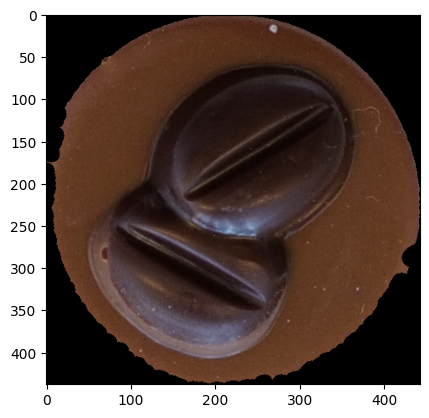

In [ ]:
for i in range(len(jpg_files)):
    if i > 1 :
        break
    
    # Transform the image to an array and make it binary
    img_path = os.path.join(path_ref, jpg_files[i])
    img = Image.open(img_path).convert('L')

    # Specific setup for different chocolates
    if i == 0 : # Armandina --> to be improved
        binary_threshold = 135
        fp = disk(30)
        nb_holes = 20000

    if i == 1 : # Arabia
        binary_threshold = 80
        fp = disk(10)
        nb_holes = 10000

    # Morphology operations
    img = np.array(img)
    img = img < binary_threshold
    footprint = fp
    img = closing(img, footprint)
    img = remove_small_holes(img, nb_holes)

    # Isolate the chocolate part of the original image
    img_ref = mpimg.imread(img_path)
    #mask = img.copy()
    masked_img = np.zeros_like(img_ref)
    masked_img[img] = img_ref[img]

    # Crop it
    coords = np.argwhere(mask) 
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # +1 because slicing is exclusive
    cropped_img = masked_img[y0:y1, x0:x1]
    plt.figure()
    plt.imshow(cropped_img)

### Edge detection ###

Shape of the 2D array: (4000, 6000)
0
Shape of the 2D array: (4000, 6000)
222
Shape of the 2D array: (4000, 6000)
0
Shape of the 2D array: (4000, 6000)
178
Shape of the 2D array: (4000, 6000)
89
Shape of the 2D array: (4000, 6000)
0
Shape of the 2D array: (4000, 6000)
0
Shape of the 2D array: (4000, 6000)
528
Shape of the 2D array: (4000, 6000)
218
Shape of the 2D array: (4000, 6000)
0
Shape of the 2D array: (4000, 6000)
180
Shape of the 2D array: (4000, 6000)
196
Shape of the 2D array: (4000, 6000)
249


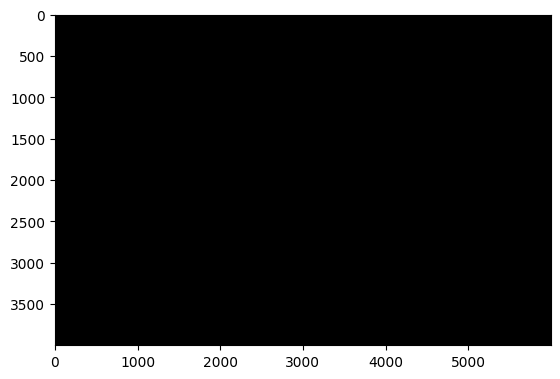

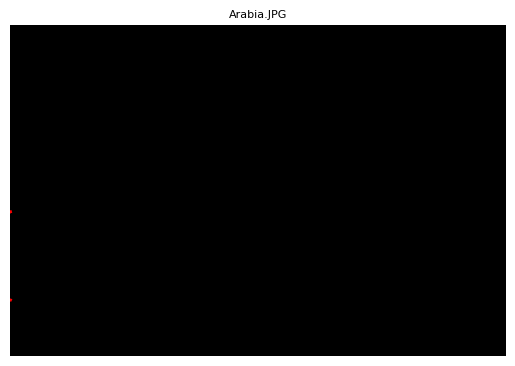

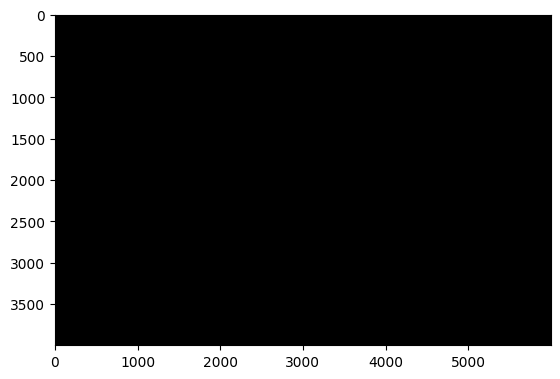

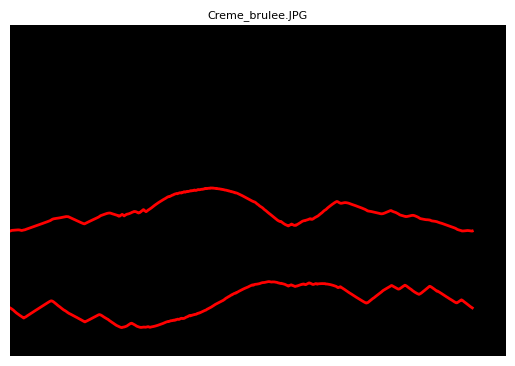

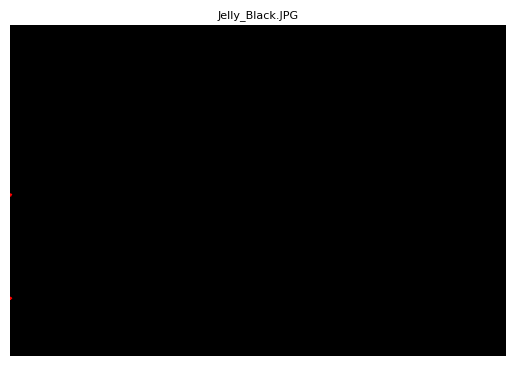

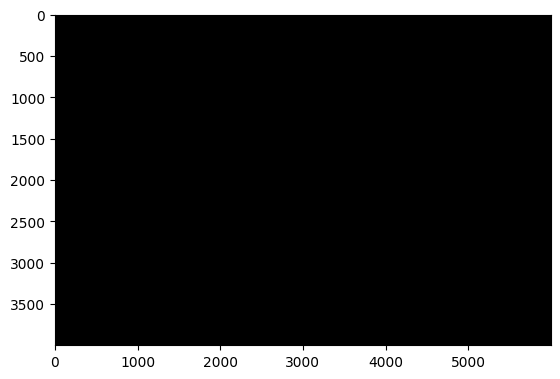

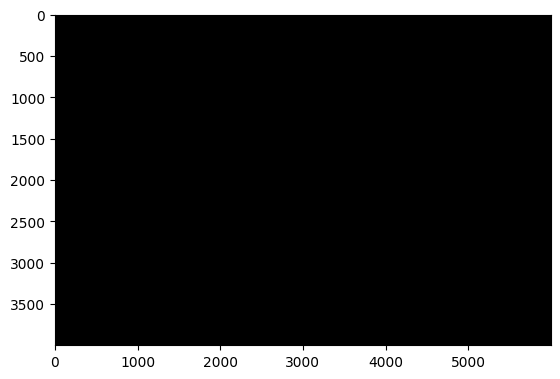

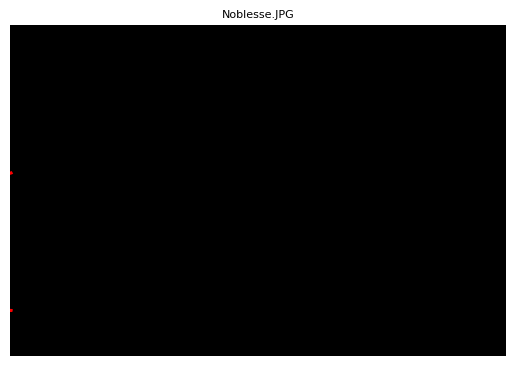

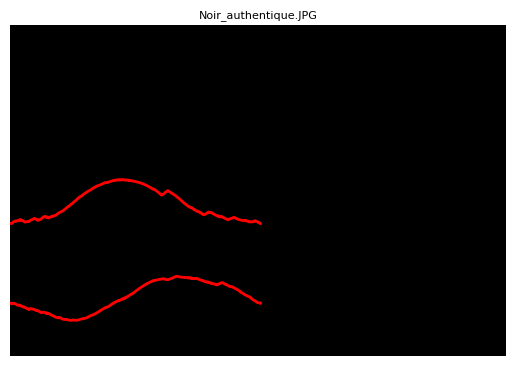

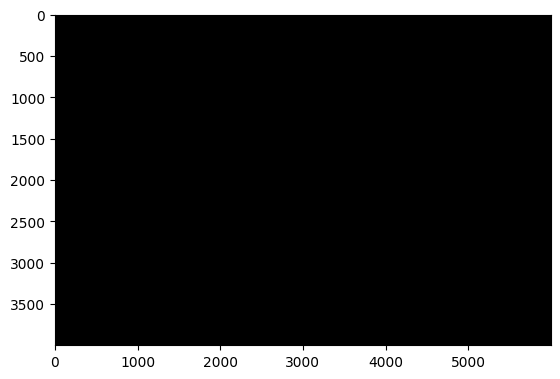

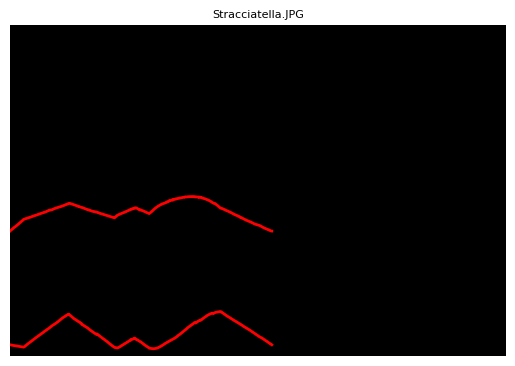

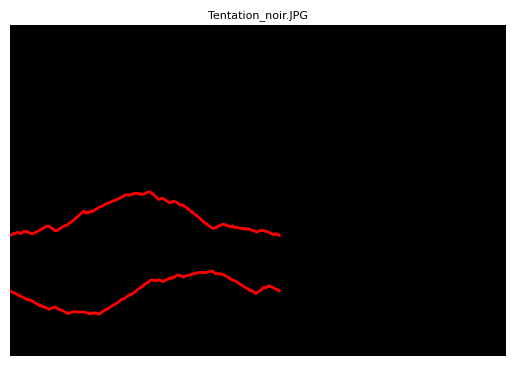

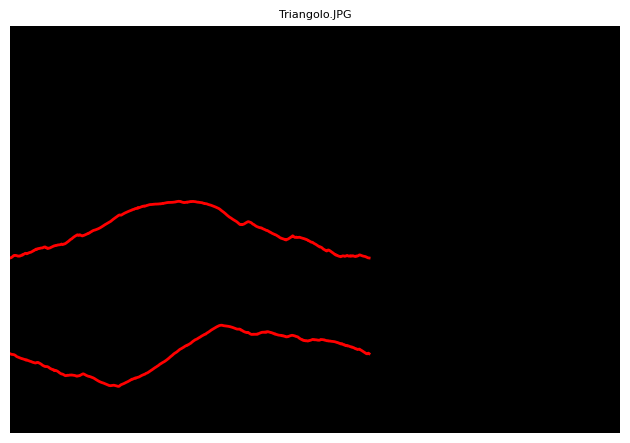

In [39]:
for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = Image.open(img_path).convert('L')
        print("Shape of the 2D array:", np.array(img).shape)
        contour = find_contours(np.array(img))
        print(len(contour))
        fig, ax = plt.subplots()
        ax.imshow(np.array(img)>0, cmap='gray')
        if len(contour) != 0:
            ax.set_title(jpg_files[i], fontsize=8)
            ax.axis('off')
            ax.plot(contour[0], linewidth=2, color='red')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

In [ ]:
contours = [np.array([[0, 0], [1, 1]]) for i in range(n_images)]

for i in range(n_images):
    img_path = os.path.join(path_ref, jpg_files[i])
    img = Image.open(img_path).convert('L')

    fig, ax = plt.subplots()
    ax.imshow(np.array(img), cmap='gray')

    contour = find_contours(np.array(img))
    if contour != []:
        longest = max(contour, key=lambda x:x.shape[0])
        contours[i] = np.fliplr(longest) 
        ax.plot(contours[i], linewidth=2, color='red')